# The ML model of CTR prediction

This is the analysis of ads generated through 11 days and known as **Avazu** data. The project follows Data Collection, EDA, Data Cleaning, modeling, it's evaluation & deployment. 

In [1]:
# Importing libraries

import numpy as np             # Mathetimatical Operations
import pandas as pd            # Data manipulation

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

# Scipy
from scipy import stats
import scipy.stats as ss

# Sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# XGBoost
import xgboost as xgb

# Other
import itertools
import tensorflow as tf
from mlxtend.preprocessing import minmax_scaling
from typing import Union
from wordcloud import WordCloud, STOPWORDS
import gzip
import timeit
import warnings
warnings.filterwarnings('ignore')

# Data collection

In [2]:
df = pd.read_csv('train.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
# validation_df = pd.read_csv('sampleSubmission.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
# test_df = pd.read_csv('test.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)

# Exploratory Data Analysis

In [3]:
# First look at the data
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


### Respective data fields

* *id*: ad identifier such as 1000009418151094273, 10000169349117863715
* *click*: 0 for non-click, 1 for click
* *hour*: in the format of YYMMDDHH, for example 21090200
* *C1*: anonymized categorical variable, such as 1005, 1002
* *banner_pos*: where a banner is located - 1 and 0
* *site_id*: site_identifier, such as 1fb01fe, fe8cc448, d6137915
* *site_domain*: hashed site category, such as 'bb1ef334', 'f3845767'
* *site_category*: hashed site category, such as 18905ebd, 28905ebd
* *app_id*: mobile app identifier
* app_domain
* app_category
* *device_id*: mobile device identifier
* *device_ip*: IP address
* *device_model*: such as iPhone6, Samsung - hashed
* *device_type*: such as tablet, smartphone - hashed
* *device_conn_type*: Wi-Fi or 3G for example - again hashed
* *C14-C21*: anonymized categorical variables

1. Looking at the data types

In [4]:
df.info()
# train_df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


2. How many observations and features there are?

In [5]:
print("Observations: " + str(len(df.index)))
print("Features: " + str(len(df.columns)))

# # Alternative way:
# train_df.shape

Observations: 40428967
Features: 24


3. Which of the features are numeric?

In [6]:
cols = df.columns
num_cols = df._get_numeric_data().columns
num_cols

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21'],
      dtype='object')

4. Which features are categorical?

In [7]:
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['device_id',
 'site_id',
 'site_domain',
 'app_domain',
 'site_category',
 'app_category',
 'device_model',
 'device_ip',
 'app_id']

5. Looking at clicks

Number of customers who didnt click on ad: 33563901
Number of customers who clicked: 6865066
Percentage of apply to non apply 4.889086426845714 %


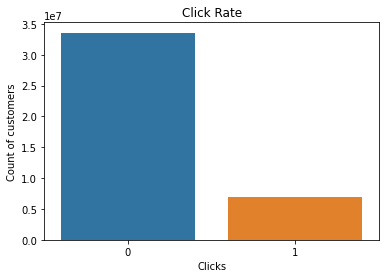

In [8]:
sns.countplot(x='click', data=df);
plt.title('Click Rate')
plt.ylabel('Count of customers')
plt.xlabel('Clicks')

print('Number of customers who didnt click on ad:',df['click'].value_counts()[0])
print('Number of customers who clicked:',df['click'].value_counts()[1])
print('Percentage of apply to non apply',df['click'].value_counts()[0]/df['click'].value_counts()[1],'%')

**Observation**
The data is imbalanced and so we might have to use techniques like resmapling (undersampling or oversampling) or use metrics like AUC-ROC curve or AUPRC or SMOTE to handle imbalanced data. Lets explore further which will help us decide what technique should we use. Note: It is already given in the dataset that I have to use AUC as the metric.

6. Checking the correlation between features


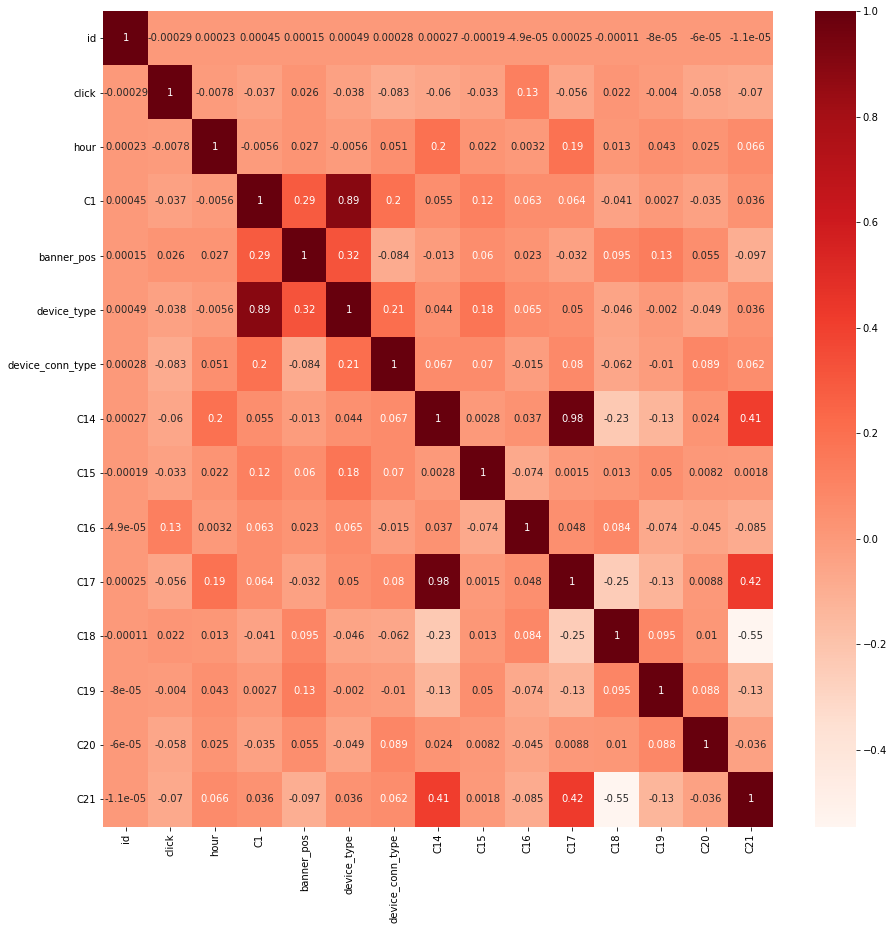

In [9]:
cor = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

**Observation:** 
After correlation and data type inspection it seems safe to drop features of 'id', 'click', 'hour', device_id' & 'device_ip'.

7. Checking outliers

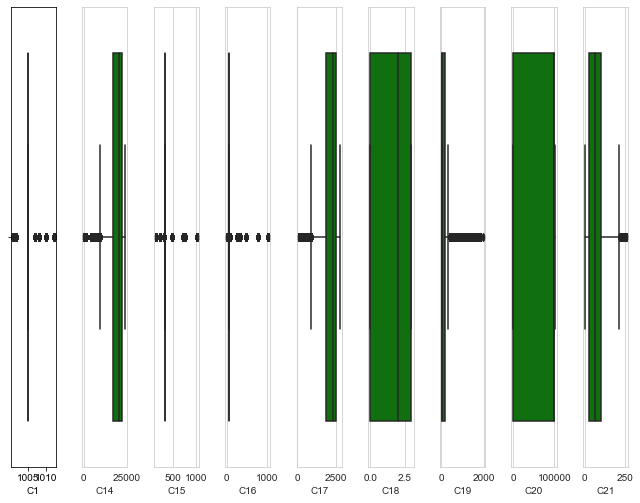

In [10]:
l = ['C1', 'C14',
       'C15', 'C16', 'C17',
       'C18','C19', 'C20', 'C21']
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,7*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()

**Observation:**
As we see there are a lot of outliers in the data

8. Checking the distribution
*Positive* refers to the fact that a customer clicked on an ad while *Negative* he/she - didn't

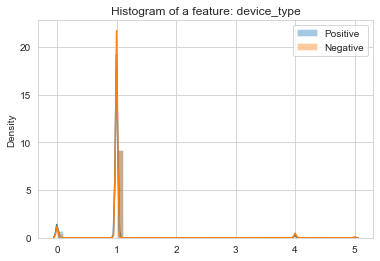

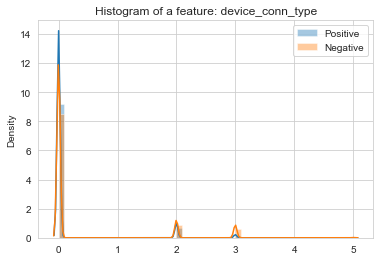

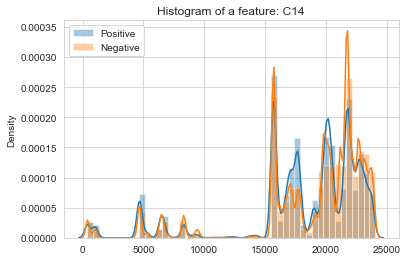

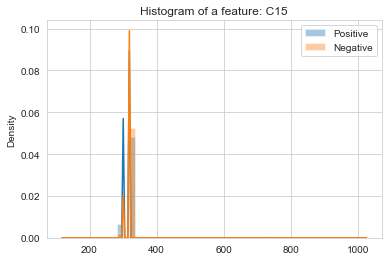

In [11]:
for feature in df.columns[14:18]:
    ax = plt.subplot()
    sns.distplot(df[df['click'] == 1][feature], bins=50, label='Positive')
    sns.distplot(df[df['click'] == 0][feature], bins=50, label='Negative')
    ax.set_xlabel('')
    ax.set_title('Histogram of a feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

**Observation:**
The linearity of some variables is a good practice to plot distribution graph and look for skewness of features. Kernel density estimate (kde) was a useful tool for plotting the shape of a distribution. From here that there seems to be some symmetry amongst the features we inspected. 


# Data Cleaning

1. Checking if there are any duplicates

In [12]:
df.duplicated(df.columns)
df.duplicated(df.columns).sum()

0

2. Checking if there are null values


In [13]:
df.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

3. Checking value counts for device_type feature

In [14]:
df['device_type'].value_counts().head()

1    37304667
0     2220812
4      774272
5      129185
2          31
Name: device_type, dtype: int64

**Observation:**
Because there aren't null values, so we don't have to consider imputing those features or dealing with null values at all.

**Note: I will not be removing outliers since there is possibility of them carrying important information which can help us detect the apply and non apply cases**

# Modelling

Involves **Feature Engineering** by removing unused features 


In [15]:
n_rows = 300000

X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values
# X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip'], axis=1).valuessite_id           object 
Y = df['click'].values

print(X.shape)

n_train = int(n_rows * 0.9)
X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]

enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(X_train)

X_train_enc[0]
print(X_train_enc[0])

X_test_enc = enc.transform(X_test)

(40428967, 19)
  (0, 2)	1.0
  (0, 6)	1.0
  (0, 188)	1.0
  (0, 2608)	1.0
  (0, 2679)	1.0
  (0, 3771)	1.0
  (0, 3885)	1.0
  (0, 3929)	1.0
  (0, 4879)	1.0
  (0, 7315)	1.0
  (0, 7319)	1.0
  (0, 7475)	1.0
  (0, 7824)	1.0
  (0, 7828)	1.0
  (0, 7869)	1.0
  (0, 7977)	1.0
  (0, 7982)	1.0
  (0, 8021)	1.0
  (0, 8189)	1.0


### Decision Tree Classifier

In [16]:
parameters = {'max_depth': [3, 10, None]}
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30)

grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

grid_search.fit(X_train_enc, Y_train)
print(grid_search.best_params_)

decision_tree_best = grid_search.best_estimator_
pos_prob = decision_tree_best.predict_proba(X_test_enc)[:, 1]

print(f'The ROC AUC on testing set is: {roc_auc_score(Y_test, pos_prob):.3f}')

{'max_depth': 10}
The ROC AUC on testing set is: 0.662


In [17]:
pos_prob = np.zeros(len(Y_test))
click_index = np.random.choice(len(Y_test), int(len(Y_test) *  51211.0/300000), replace=False)
pos_prob[click_index] = 1

print(f'The ROC AUC on testing set is: {roc_auc_score(Y_test, pos_prob):.3f}')

The ROC AUC on testing set is: 0.500


### Random Forest Classifier

In [18]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)
grid_search.fit(X_train_enc, Y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': None}
0.7357174132947599


In [19]:
random_forest_best = grid_search.best_estimator_
pos_prob = random_forest_best.predict_proba(X_test_enc)[:, 1]
print(f'The ROC AUC on testing set is: {roc_auc_score(Y_test, pos_prob):.3f}')

The ROC AUC on testing set is: 0.691


### XGB Classifier

In [20]:
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=1000, eval_metric='logloss')

model.fit(X_train_enc, Y_train)
pos_prob = model.predict_proba(X_test_enc)[:, 1]

print(f'The ROC AUC on testing set is: {roc_auc_score(Y_test, pos_prob):.3f}')

[20:55:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The ROC AUC on testing set is: 0.699


# Adam optimization & changes

In [9]:
# Importing libraries

import numpy as np             # Mathetimatical Operations
import pandas as pd            # Data manipulation
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

# Scipy
from scipy import stats
import scipy.stats as ss

# Sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# XGBoost
import xgboost as xgb

# Tensorflow
import tensorflow as tf

# Other
import itertools
from tqdm import tqdm
from mlxtend.preprocessing import minmax_scaling
from typing import Union
from wordcloud import WordCloud, STOPWORDS
import gzip
import timeit
import warnings
warnings.filterwarnings('ignore')

In [10]:
n_rows = 300000
n_train = int(n_rows * 0.9)

df = pd.read_csv('data/train.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)

X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values
# X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip'], axis=1).valuessite_id           object 
Y = df['click'].values

In [11]:
X_train = X[:n_train]
Y_train = Y[:n_train].astype('float32')
X_test = X[n_train:]
Y_test = Y[n_train:].astype('float32')

In [12]:
enc = OneHotEncoder(handle_unknown='ignore')

In [13]:
X_train_enc = enc.fit_transform(X_train).toarray().astype('float32')
print(X_train_enc)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [14]:
X_test_enc = enc.transform(X_test)
print(X_test_enc)

  (0, 2)	1.0
  (0, 7)	1.0
  (0, 1393)	1.0
  (0, 2130)	1.0
  (0, 2677)	1.0
  (0, 3771)	1.0
  (0, 3885)	1.0
  (0, 3929)	1.0
  (0, 4354)	1.0
  (0, 7315)	1.0
  (0, 7318)	1.0
  (0, 7681)	1.0
  (0, 7824)	1.0
  (0, 7828)	1.0
  (0, 7905)	1.0
  (0, 7977)	1.0
  (0, 7982)	1.0
  (0, 8021)	1.0
  (0, 8202)	1.0
  (1, 2)	1.0
  (1, 7)	1.0
  (1, 1231)	1.0
  (1, 2041)	1.0
  (1, 2696)	1.0
  (1, 3771)	1.0
  :	:
  (40158965, 7318)	1.0
  (40158965, 7502)	1.0
  (40158965, 7824)	1.0
  (40158965, 7828)	1.0
  (40158965, 7882)	1.0
  (40158965, 7980)	1.0
  (40158965, 7983)	1.0
  (40158965, 8150)	1.0
  (40158965, 8175)	1.0
  (40158966, 2)	1.0
  (40158966, 6)	1.0
  (40158966, 188)	1.0
  (40158966, 2608)	1.0
  (40158966, 2679)	1.0
  (40158966, 3771)	1.0
  (40158966, 3885)	1.0
  (40158966, 3929)	1.0
  (40158966, 5420)	1.0
  (40158966, 7315)	1.0
  (40158966, 7318)	1.0
  (40158966, 7824)	1.0
  (40158966, 7828)	1.0
  (40158966, 7977)	1.0
  (40158966, 8001)	1.0
  (40158966, 8080)	1.0


In [ ]:
batch_size = 1000
train_data = tf.data.Dataset.from_tensor_slices((X_train_enc, Y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [ ]:
n_features = int(X_train_enc.shape[1])
W = tf.Variable(tf.zeros([n_features, 1]))
b = tf.Variable(tf.zeros([1]))

In [ ]:
learning_rate = 0.0008
optimizer = tf.optimizers.Adam(learning_rate)

In [ ]:
def run_optimization(x, y):
    with tf.GradientTape() as g:
        logits = tf.add(tf.matmul(x, W), b)[:, 0]
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits))
    gradients = g.gradient(cost, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [ ]:
training_steps = 6000
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)
    if step % 500 == 0:
        logits = tf.add(tf.matmul(batch_x, W), b)[:, 0]
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=batch_y, logits=logits))
        print("step: %i, loss: %f" % (step, loss))

In [ ]:
logits = tf.add(tf.matmul(X_test_enc, W), b)[:, 0]
pred = tf.nn.sigmoid(logits)
auc_metric = tf.keras.metrics.AUC()
auc_metric.update_state(Y_test, pred)

print(f'AUC on testing set: {auc_metric.result().numpy():.3f}')

## Random Forest Classifier Again

In [3]:
n_rows = 100000

X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values
# X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip'], axis=1).valuessite_id           object 
Y = df['click'].values

X_train = X
Y_train = Y

enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(X_train)

NameError: name 'df' is not defined

### Feature Selection

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)
random_forest.fit(X_train_enc.toarray(), Y_train)

feature_imp = random_forest.feature_importances_
print(feature_imp)

*Bottom 10 weights and the corresponding 10 least important features*

In [21]:
feature_names = enc.get_feature_names()
print(np.sort(feature_imp)[:10])
bottom_10 = np.argsort(feature_imp)[:10]
print('10 least important features are:\n', feature_names[bottom_10])

NameError: name 'feature_imp' is not defined

*Top 10 weights and the corresponding 10 most important features*


In [ ]:
print(np.sort(feature_imp)[-10:])
top_10 = np.argsort(feature_imp)[-10:]
print('10 most important features are:\n', feature_names[top_10])

**Defining the values to be used for further modelling**

In [ ]:
n_train = 100000
X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]

enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(X_train)

X_test_enc = enc.transform(X_test)

# SGDC Classifier

In [ ]:
sgd_lr = SGDClassifier(loss='log', penalty=None, fit_intercept=True, max_iter=10, learning_rate='constant', eta0=0.01)
sgd_lr.fit(X_train_enc.toarray(), Y_train)

pred = sgd_lr.predict_proba(X_test_enc.toarray())[:, 1]
print(f'Training samples: {n_train}, AUC on testing set: {roc_auc_score(Y_test, pred):.3f}')

**Feature selection with L1 regularization**

In [ ]:
sgd_lr_l1 = SGDClassifier(loss='log', penalty='l1', alpha=0.0001, fit_intercept=True, max_iter=10, learning_rate='constant', eta0=0.01)
sgd_lr_l1.fit(X_train_enc.toarray(), Y_train)

coef_abs = np.abs(sgd_lr_l1.coef_)
print(coef_abs)

*Bottom 10 weights and the corresponding 10 least important features*


In [ ]:
print(np.sort(coef_abs)[0][:10])

feature_names = enc.get_feature_names()
bottom_10 = np.argsort(coef_abs)[0][:10]
print('10 least important features are:\n', feature_names[bottom_10])

*Top 10 weights and the corresponding 10 most important features*

In [ ]:
print(np.sort(coef_abs)[0][-10:])
top_10 = np.argsort(coef_abs)[0][-10:]
print('10 most important features are:\n', feature_names[top_10])

### Online learning with SGDC

In [ ]:
n_rows = 100000 * 11

n_train = 100000 * 10
X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)

In [ ]:
# The number of iterations is set to 1 if using partial_fit

sgd_lr_online = SGDClassifier(loss='log', penalty=None, fit_intercept=True, max_iter=1, learning_rate='constant',
                              eta0=0.01)

start_time = timeit.default_timer()


# Use the first 1,000,000 samples for training, and the next 100,000 for testing

for i in range(10):
    x_train = X_train[i*100000:(i+1)*100000]
    y_train = Y_train[i*100000:(i+1)*100000]
    x_train_enc = enc.transform(x_train)
    sgd_lr_online.partial_fit(x_train_enc.toarray(), y_train, classes=[0, 1])

print(f"--- {(timeit.default_timer() - start_time)}.3fs seconds ---")

x_test_enc = enc.transform(X_test)

pred = sgd_lr_online.predict_proba(x_test_enc.toarray())[:, 1]
print(f'Training samples: {n_train * 10}, AUC on testing set: {roc_auc_score(Y_test, pred):.3f}')

# Logistic Regression

In [ ]:
# Multiclass classification

digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
Y = digits.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
parameters = {'penalty': ['l2', None],
              'alpha': [1e-07, 1e-06, 1e-05, 1e-04],
              'eta0': [0.01, 0.1, 1, 10]}

sgd_lr = SGDClassifier(loss='log', learning_rate='constant', eta0=0.01, fit_intercept=True, max_iter=10)

grid_search = GridSearchCV(sgd_lr, parameters, n_jobs=-1, cv=5)

grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

sgd_lr_best = grid_search.best_estimator_
accuracy = sgd_lr_best.score(X_test, Y_test)
print(f'The accuracy on testing set is: {accuracy*100:.1f}%')

# Conclusion

**Using the models we get:**
* Decision Tree Classifier gives ROC AUC on testing set to be 0.662, so it is a poor classification.
* Even though Random Forest Classifier with ROC AUC of 692 is better, but it still gives a poor classification.
* XGB Classifier gives ROC AUC of 0.699, so it closer to fair classification but still not so.